In [1]:
import pubchempy as pcp
import pandas as pd
import numpy as np
import seaborn as sns

from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

from mordred import Calculator, descriptors
from mordred import  ABCIndex

import matplotlib.pyplot as plt
from statistics import mean
from math import sqrt
from rdkit import Chem
from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [17]:
PRTR_df = pd.read_excel("/Users/raysmith/Desktop/研究室/modeling of biodegradation/PRTR.xlsx", header=0)
PRTR_df = pd.DataFrame(PRTR_df)
PRTR_df = PRTR_df.iloc[11:,1:4]
PRTR_df.columns = ["No","CAS","Name"]
drop_PRTR_df = PRTR_df[PRTR_df["CAS"] == "-"]
PRTR_df = PRTR_df[PRTR_df["CAS"] != "-"]
PRTRs_df = PRTR_df[PRTR_df["CAS"].str.contains("\n")]
PRTR_df = PRTR_df[~PRTR_df["CAS"].str.contains("\n")]
for i in PRTRs_df.itertuples():
    print(i.No)
    tem_cas = i.CAS
    tem_list = tem_cas.splitlines()
    for j in tem_list:
        print([i.No,j,i.Name])
        PRTR_df = PRTR_df.append({"No":i.No,"CAS":j,"Name":i.Name},ignore_index=True)
        
PRTR_df = PRTR_df.sort_values('No')
PRTR_df

FileNotFoundError: [Errno 2] No such file or directory: '/Users/raysmith/Desktop/研究室/modeling of biodegradation/PRTR.xlsx'

In [6]:
PRTR_df.head(20)

,No,CAS,Name
0,2,79-06-1,アクリルアミド
1,3,140-88-5,アクリル酸エチル
2,5,2439-35-2,アクリル酸２－（ジメチルアミノ）エチル
3,6,818-61-1,アクリル酸２－ヒドロキシエチル
4,7,141-32-2,アクリル酸ノルマル－ブチル
5,8,96-33-3,アクリル酸メチル
6,9,107-13-1,アクリロニトリル
7,10,107-02-8,アクロレイン
8,11,26628-22-8,アジ化ナトリウム
9,12,75-07-0,アセトアルデヒド


In [7]:
import requests
import json

api = "https://cactus.nci.nih.gov/chemical/structure/{CAS}/smiles"
prtr_smiles_list = []
for i in PRTR_df.itertuples():
    cas = i.CAS
    url = api.format(CAS = cas)
    r = requests.get(url)
    prtr_smiles_list.append(r.text)
    print(r.text)
prtr_smiles_df = pd.DataFrame(prtr_smiles_list)

SSLError: HTTPSConnectionPool(host='cactus.nci.nih.gov', port=443): Max retries exceeded with url: /chemical/structure/79-06-1/smiles (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1091)')))

In [1]:
r = requests.get('https://cactus.nci.nih.gov/chemical/structure/2439-35-2/smiles')
r.text

NameError: name 'requests' is not defined

In [ ]:
prtr_smiles_df.columns = ["CanonicalSMILES"]
prtr_smiles_df.to_csv("prtr_smiles.csv",header=False,index=False, columns=['CanonicalSMILES'])

In [ ]:
prtr_df_list = []
properties = ['IUPACName', 'MolecularFormula','CanonicalSMILES']
prtr_df = []
for i in prtr_smiles_df.itertuples():
    print(i.CanonicalSMILES)
    try:
        prtr_df_list.append(pd.DataFrame(pcp.get_properties(properties, i.CanonicalSMILES,'smiles')))
    except:
        print('Error')
prtr_df = pd.concat(prtr_df_list, axis=0)
prtr_df

In [ ]:
prtr_df.to_csv("prtr_smiles.csv",header=False,index=False, columns=['CanonicalSMILES'])

In [2]:
features_list_TCAA_rf = ["SsOH",
                         "C2SP2",
                        "SlogP_VSA11",
                        "SMR_VSA7",
                        "PEOE_VSA1",
                        "EState_VSA7",
                        "ATSC5are",
                        "nBondsKD",
                        "ATS1i",
                        "nBondsM"]

features_list_DCAA_rf = ["AATSC0are",
                         "ATSC3dv",
                         "SlogP_VSA11",
                         "ATS4m",
                         "ATS4Z",
                         "Xch-7d",
                         "PEOE_VSA1",
                         "SaasC",
                         "piPC4",
                         "VSA_EState9"]
features_list_TCAA_DCAA_rf = ["SsOH",
                         "C2SP2",
                        "SlogP_VSA11",
                        "SMR_VSA7",
                        "PEOE_VSA1",
                        "EState_VSA7",
                        "ATSC5are",
                        "nBondsKD",
                        "ATS1i",
                        "nBondsM",
                        "AATSC0are",
                        "ATSC3dv",
                        "ATS4m",
                        "ATS4Z",
                        "Xch-7d",
                        "SaasC",
                        "piPC4",
                        "VSA_EState9" ] 

calc_dummy = Calculator(descriptors, ignore_3D=False)
my_desc_names_TCAA = features_list_TCAA_rf
my_desc_names_DCAA = features_list_DCAA_rf
my_desc_names_TCAA_DCAA = features_list_TCAA_DCAA_rf                        
my_descs = []
for i, desc in enumerate(calc_dummy.descriptors):
    if desc.__str__()  in my_desc_names_TCAA:
       my_descs.append(desc)

calc_TCAA = Calculator(my_descs, ignore_3D=False)
my_descs = []
for i, desc in enumerate(calc_dummy.descriptors):
    if desc.__str__()  in my_desc_names_DCAA:
       my_descs.append(desc)

calc_DCAA = Calculator(my_descs, ignore_3D=False)
my_descs = []
for i, desc in enumerate(calc_dummy.descriptors):
    if desc.__str__()  in my_desc_names_TCAA_DCAA:
       my_descs.append(desc)

calc_TCAA_DCAA = Calculator(my_descs, ignore_3D=False)

In [3]:
calc=calc_TCAA_DCAA

In [4]:
mols = pd.read_excel("/Users/moriirei/Desktop/研究室/modeling of biodegradation/database_updated_20200504.xlsx", header=0)
df_result = mols[['DCAA (umol/mmol)', 'TCAA (umol/mmol)', 'HAAFP (umol/mmol)']]
Y = df_result.values
df_result = mols[['SMILES','DCAA (umol/mmol)', 'TCAA (umol/mmol)', 'HAAFP (umol/mmol)']]
PandasTools.AddMoleculeColumnToFrame(df_result, smilesCol='SMILES', includeFingerprints=False)
log_Y = np.log1p(Y)

In [5]:
exp_descriptor_data = pd.DataFrame(calc.pandas(df_result['ROMol']))
X_Exp_TCAA = exp_descriptor_data[features_list_TCAA_rf]
X_Exp_DCAA = exp_descriptor_data[features_list_DCAA_rf]

100%|██████████| 283/283 [00:00<00:00, 639.67it/s]


In [6]:
pipe_DCAA_rf = Pipeline(
    [
        ('std_scaler', StandardScaler()),
        ("RF", RandomForestRegressor(random_state = 17,
                                    n_estimators = 300,
                                    max_features = "auto",
                                    min_samples_split = 0.03,
                                    min_samples_leaf = 0.01,
                                    max_depth = 30,
                                    max_leaf_nodes = None,
                                    n_jobs = 1))
    ]
)

pipe_TCAA_rf = Pipeline(
    [
        ('std_scaler', StandardScaler()),
        ("RF", RandomForestRegressor(random_state = 17,
                                    n_estimators = 100,
                                    max_features = "auto",
                                     min_samples_split = 2,
                                     min_samples_leaf = 1,
                                     max_depth = None,
                                     max_leaf_nodes = None,
                                    n_jobs = 1))
    ]
)
pipe_TCAA_rf.fit(X_Exp_TCAA, log_Y[:,1])
pipe_DCAA_rf.fit(X_Exp_DCAA, log_Y[:,0])

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('RF',
                 RandomForestRegressor(max_depth=30, min_samples_leaf=0.01,
                                       min_samples_split=0.03, n_estimators=300,
                                       n_jobs=1, random_state=17))])

In [7]:
intermediate_df = pd.read_excel("excel_py/prtr_results.xlsx", header=0)
intermediate_df = intermediate_df.iloc[4:]
target_list = intermediate_df.iloc[0,1:]
target_list = target_list.rename("target")
intermediate_list = intermediate_df.iloc[1:,0]
intermediate_list = intermediate_list.rename("intermediate")
intermediate_df = intermediate_df.iloc[1:,1:]
intermediate_df.index = intermediate_list
intermediate_df.columns = target_list

In [8]:
intermediate_dic = {}
for target in target_list:
    tem_df = pd.DataFrame(intermediate_df[target].dropna())
    tem_df['target'] = tem_df.index
    tem_df.loc['target'] = target
    tem_df = tem_df.drop(target, axis=1)
    PandasTools.AddMoleculeColumnToFrame(tem_df, smilesCol='target', includeFingerprints=False)
    tem_df = tem_df.dropna(subset=['ROMol'])
    intermediate_dic[target] = tem_df

In [9]:
for target in target_list:
    tem_df = intermediate_dic[target]
    tem_mol_list = tem_df['ROMol']
    tem_qsar_preview = pd.DataFrame(calc.pandas(tem_mol_list, nproc=4).fill_missing())
    intermediate_dic[target] = pd.concat([tem_df, tem_qsar_preview], axis=1)

100%|██████████| 6/6 [00:00<00:00, 138.08it/s]


In [10]:
result_intermediate_dic = {}
for target in target_list:
    tem_df = intermediate_dic[target]
    tem_ext_TCAA_df = tem_df[features_list_TCAA_rf]
    tem_ext_DCAA_df = tem_df[features_list_DCAA_rf]
    tem_Y_predicted_TCAA_rf = pipe_TCAA_rf.predict(tem_ext_TCAA_df)
    tem_Y_predicted_DCAA_rf = pipe_DCAA_rf.predict(tem_ext_DCAA_df)
    tem_predicted_TCAA_df = pd.DataFrame(tem_Y_predicted_TCAA_rf)
    tem_predicted_TCAA_df.columns = ["TCAA"]
    tem_predicted_TCAA_df.index = tem_df.index
    tem_predicted_DCAA_df = pd.DataFrame(tem_Y_predicted_DCAA_rf)
    tem_predicted_DCAA_df.columns = ["DCAA"]
    tem_predicted_DCAA_df.index = tem_df.index
    tem_result_TCAA_DCAA_df = pd.concat([tem_predicted_TCAA_df,tem_predicted_DCAA_df, tem_df], axis=1)
    tem_result_TCAA_DCAA_df = tem_result_TCAA_DCAA_df.sort_values(by = ["TCAA"], ascending = False)
    result_intermediate_dic[target] = tem_result_TCAA_DCAA_df

In [19]:
TCAAFP_increase_category1 = [] 
TCAAFP_increase_category2 = [] 
TCAAFP_increase_category3 = [] 
TCAAFP_increase_category2_category3 = [] 
TCAAFP_increase_category4 = []
DCAAFP_increase_category1 = [] 
DCAAFP_increase_category2 = [] 
DCAAFP_increase_category3 = [] 
DCAAFP_increase_category2_category3 = [] 
DCAAFP_increase_category4 = []
TCAAFP_DCAAFP_increase_category1 = [] 
TCAAFP_DCAAFP_increase_category2 = [] 
TCAAFP_DCAAFP_increase_category3 = [] 
TCAAFP_DCAAFP_increase_category2_category3 = [] 
TCAAFP_DCAAFP_increase_category4 = []
for target in target_list:
    tem_df = result_intermediate_dic[target]
    if tem_df["target"].loc[tem_df["TCAA"].idxmax()] != target:
        TCAAFP_increase_category1.append(tem_df)
    if tem_df["TCAA"].max()/tem_df["TCAA"].loc["target"] >= 10:
        TCAAFP_increase_category2.append(tem_df)
    if tem_df["target"].loc[tem_df["TCAA"].idxmin()] == target:
        TCAAFP_increase_category3.append(tem_df)
        if tem_df["TCAA"].max()/tem_df["TCAA"].loc["target"] >= 10:
            TCAAFP_increase_category2_category3.append(tem_df)
    if tem_df["TCAA"].loc["target"] < 2 and tem_df["TCAA"].max() > 4:
        TCAAFP_increase_category4.append(tem_df)
            
    if tem_df["target"].loc[tem_df["DCAA"].idxmax()] != target:
        DCAAFP_increase_category1.append(tem_df)
    if tem_df["DCAA"].max()/tem_df["DCAA"].loc["target"] >= 10:
        DCAAFP_increase_category2.append(tem_df)
    if tem_df["target"].loc[tem_df["DCAA"].idxmin()] == target:
        DCAAFP_increase_category3.append(tem_df)
        if tem_df["DCAA"].max()/tem_df["DCAA"].loc["target"] >= 10:
            DCAAFP_increase_category2_category3.append(tem_df)
    if tem_df["DCAA"].loc["target"] < 1 and tem_df["DCAA"].max() > 2:
        DCAAFP_increase_category4.append(tem_df)       
            
    if tem_df["target"].loc[tem_df["TCAA"].idxmax()] != target and tem_df["target"].loc[tem_df["DCAA"].idxmax()]:
        TCAAFP_DCAAFP_increase_category1.append(tem_df)
    if tem_df["TCAA"].max()/tem_df["TCAA"].loc["target"] >= 10 and tem_df["DCAA"].max()/tem_df["DCAA"].loc["target"] >= 10:
        TCAAFP_DCAAFP_increase_category2.append(tem_df)
    if tem_df["target"].loc[tem_df["TCAA"].idxmin()] == target and tem_df["target"].loc[tem_df["DCAA"].idxmin()] == target:
        TCAAFP_DCAAFP_increase_category3.append(tem_df)
        if tem_df["TCAA"].max()/tem_df["TCAA"].loc["target"] >= 10 and tem_df["DCAA"].max()/tem_df["DCAA"].loc["target"] >= 10 :
            TCAAFP_DCAAFP_increase_category2_category3.append(tem_df)
    if tem_df["TCAA"].loc["target"] < 2 and tem_df["TCAA"].max() > 4 and tem_df["DCAA"].loc["target"] < 1 and tem_df["DCAA"].max() > 2:
        TCAAFP_DCAAFP_increase_category4.append(tem_df)

,TCAA,DCAA,target,ROMol,ATS4Z,ATS4m,ATS1i,ATSC3dv,ATSC5are,AATSC0are,nBondsM,nBondsKD,C2SP2,Xch-7d,SaasC,SsOH,PEOE_VSA1,SMR_VSA7,SlogP_VSA11,EState_VSA7,VSA_EState9,piPC4
intermediate,,,,,,,,,,,,,,,,,,,,,,
Oc1ccc(O)c(O)c1,4.490888,2.486366,Oc1ccc(O)c(O)c1,,315.0,1043.266032,2235.716595,-25.680000,0.755200,0.229600,6,3,6,0.204124,-0.603611,26.039074,15.319582,18.199101,17.248535,0.0,29.000000,3.986667
Oc1ccc(O)c(O)c1O,4.450249,2.146491,Oc1ccc(O)c(O)c1O,,462.0,1564.964886,2421.121652,-7.171875,0.060313,0.264844,6,3,6,0.222222,-2.342037,34.861111,20.426110,12.132734,22.998047,0.0,34.666667,4.141149
target,1.228337,0.971482,C1=CC(=CC=C1O)O,,182.0,551.789034,2050.311538,-31.204082,1.573265,0.181224,6,3,6,0.166667,0.338519,17.291111,10.213055,24.265468,11.499024,0.0,23.333333,3.803881
[O-]C(=O)CC(=O)\C=C/C([O-])=O,1.126041,2.527390,[O-]C(=O)CC(=O)\C=C/C([O-])=O,,490.0,1860.125645,2013.178613,-71.506667,0.629156,0.293156,4,4,3,0.000000,0.000000,0.000000,19.802129,12.152040,0.000000,0.0,45.500000,3.178054

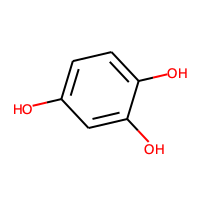
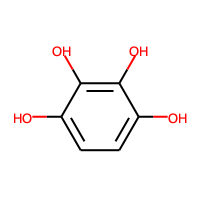
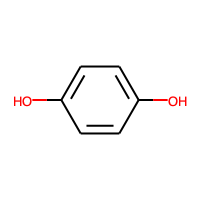
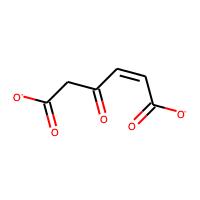

In [12]:
result_intermediate_dic["C1=CC(=CC=C1O)O"]

In [13]:
prtr_TCAA_list2_3_target_smiles_df = []
prtr_TCAA_list2_3_target_list = []
properties = ['IUPACName', 'MolecularFormula','CanonicalSMILES']
for i in TCAAFP_increase_category2_category3:
    tem_df = pd.DataFrame(pcp.get_properties(properties, i["target"].loc["target"],'smiles'))
    tem_df["target_TCAA"] = i["TCAA"].loc["target"] 
    tem_df["max_TCAA"] = i["TCAA"].max()
    prtr_TCAA_list2_3_target_list.append(tem_df)
prtr_TCAA_list2_3_target_df = pd.concat(prtr_TCAA_list2_3_target_list, axis=0)
prtr_TCAA_list2_3_target_df
prtr_TCAA_list2_3_target_df.to_csv("excel_prtr/prtr_TCAA_category2and3.csv",header=True,index=False)

prtr_DCAA_list2_3_target_smiles_df = []
prtr_DCAA_list2_3_target_list = []
properties = ['IUPACName', 'MolecularFormula','CanonicalSMILES']
for i in DCAAFP_increase_category2_category3:
    tem_df = pd.DataFrame(pcp.get_properties(properties, i["target"].loc["target"],'smiles'))
    tem_df["target_DCAA"] = i["DCAA"].loc["target"] 
    tem_df["max_DCAA"] = i["DCAA"].max()
    prtr_DCAA_list2_3_target_list.append(tem_df)
prtr_DCAA_list2_3_target_df = pd.concat(prtr_DCAA_list2_3_target_list, axis=0)
prtr_DCAA_list2_3_target_df
prtr_DCAA_list2_3_target_df.to_csv("excel_prtr/prtr_DCAA_category2and3.csv",header=True,index=False)

prtr_TCAA_DCAA_list2_3_target_smiles_df = []
prtr_TCAA_DCAA_list2_3_target_list = []
properties = ['IUPACName', 'MolecularFormula','CanonicalSMILES']
for i in TCAAFP_DCAAFP_increase_category2_category3:
    tem_df = pd.DataFrame(pcp.get_properties(properties, i["target"].loc["target"],'smiles'))
    tem_df["target_TCAA"] = i["TCAA"].loc["target"] 
    tem_df["max_TCAA"] = i["TCAA"].max()
    tem_df["target_DCAA"] = i["DCAA"].loc["target"] 
    tem_df["max_DCAA"] = i["DCAA"].max()
    prtr_TCAA_DCAA_list2_3_target_list.append(tem_df)
prtr_TCAA_DCAA_list2_3_target_df = pd.concat(prtr_TCAA_DCAA_list2_3_target_list, axis=0)
prtr_TCAA_DCAA_list2_3_target_df
prtr_TCAA_DCAA_list2_3_target_df.to_csv("excel_prtr/prtr_TCAA_DCAA_category2and3.csv",header=True,index=False)

ValueError: No objects to concatenate

In [ ]:
prtr_DCAA_list2_target_smiles_df = []
prtr_DCAA_list2_target_list = []
properties = ['IUPACName', 'MolecularFormula','CanonicalSMILES']
for i in DCAAFP_increase_category2:
    tem_df = pd.DataFrame(pcp.get_properties(properties, i["target"].loc["target"],'smiles'))
    tem_df["target_DCAA"] = i["DCAA"].loc["target"] 
    tem_df["max_DCAA"] = i["DCAA"].max()
    prtr_DCAA_list2_target_list.append(tem_df)
prtr_DCAA_list2_target_df = pd.concat(prtr_DCAA_list2_target_list, axis=0)
prtr_DCAA_list2_target_df
prtr_DCAA_list2_target_df.to_csv("excel_prtr/prtr_DCAA_category2.csv",header=True,index=False)

prtr_DCAA_list3_target_smiles_df = []
prtr_DCAA_list3_target_list = []
properties = ['IUPACName', 'MolecularFormula','CanonicalSMILES']
for i in DCAAFP_increase_category3:
    tem_df = pd.DataFrame(pcp.get_properties(properties, i["target"].loc["target"],'smiles'))
    tem_df["target_DCAA"] = i["DCAA"].loc["target"] 
    tem_df["max_DCAA"] = i["DCAA"].max()
    prtr_DCAA_list3_target_list.append(tem_df)
prtr_DCAA_list3_target_df = pd.concat(prtr_DCAA_list3_target_list, axis=0)
prtr_DCAA_list3_target_df
prtr_DCAA_list3_target_df.to_csv("excel_prtr/prtr_DCAA_category3.csv",header=True,index=False)

,CID,MolecularFormula,CanonicalSMILES,IUPACName,target_TCAA,max_TCAA,target_DCAA,max_DCAA,target_TCAA_position,target_DCAA_position,ROMol
0,7252,C7H10N2,CC1=C(C=CC(=C1)N)N,"2-methylbenzene-1,4-diamine",2.485385,175.369029,3.972769,56.281471,9/10,9/10,
0,7238,C7H7Cl,CC1=CC=CC=C1Cl,1-chloro-2-methylbenzene,0.527481,92.141353,0.970424,58.423802,9/10,9/10,
0,8445,C8H11NO,CC1=CC(=C(C=C1)OC)N,2-methoxy-5-methylaniline,1.765563,216.631187,3.301203,86.461293,8/10,8/10,
0,240,C7H6O,C1=CC=C(C=C1)C=O,benzaldehyde,0.937555,177.521318,0.840258,139.707426,5/5,5/5,
0,3031,C7H3Cl2N,C1=CC(=C(C(=C1)Cl)C#N)Cl,"2,6-dichlorobenzonitrile",0.777057,160.307422,2.038716,99.535172,7/7,7/7,
0,7810,C7H7Cl,CC1=CC=C(C=C1)Cl,1-chloro-4-methylbenzene,0.633427,87.584474,1.013809,66.316724,5/6,5/6,
0,7242,C7H9N,CC1=CC=CC=C1N,2-methylaniline,3.863859,172.186483,3.177594,63.948907,10/11,10/11,
0,7017,C12H10O,C1=CC=C(C=C1)C2=CC=CC=C2O,2-phenylphenol,5.609822,81.059633,5.697122,56.432244,6/9,6/9,
0,24744,C16H16N2O4,CC1=CC(=CC=C1)NC(=O)OC2=CC=CC(=C2)NC(=O)OC,[3-(methoxycarbonylamino)phenyl] N-(3-methylph...,5.315888,83.418428,4.743767,85.254611,18/21,18/21,
0,7813,C7H9N,CC1=CC=C(C=C1)N,4-methylaniline,1.677260,170.855923,2.921852,85.254611,6/7,6/7,

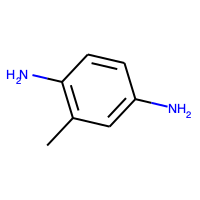
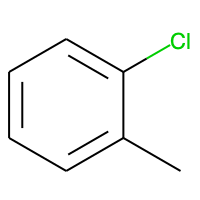
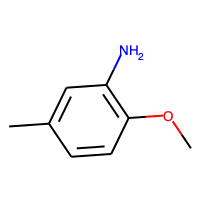
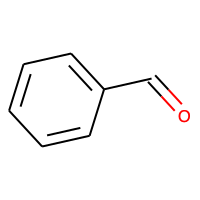
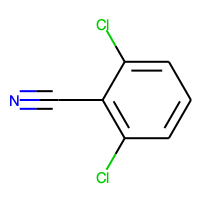
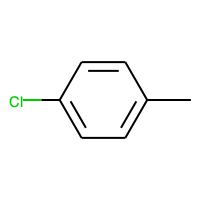
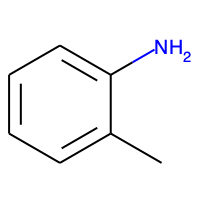
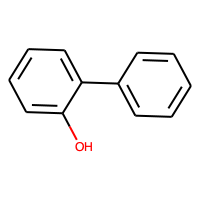
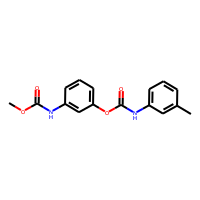
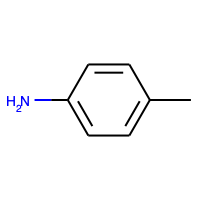
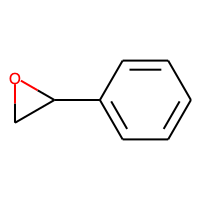
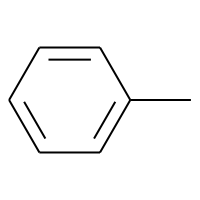
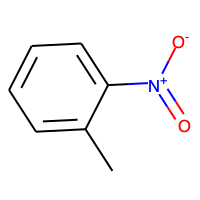

In [127]:
prtr_TCAA_list4_target_smiles_df = []
prtr_TCAA_list4_target_list = []
properties = ['IUPACName', 'MolecularFormula','CanonicalSMILES']
for i in TCAAFP_increase_category4:
    tem_df = pd.DataFrame(pcp.get_properties(properties, i["target"].loc["target"],'smiles'))
    tem_df["target_TCAA"] = np.exp(i["TCAA"].loc["target"])-1
    tem_df["max_TCAA"] = np.exp(i["TCAA"].max())-1
    tem_df["target_TCAA_position"] = str(int(i["TCAA"].rank(ascending = False).loc["target"])) + "/" + str(len(i))
    PandasTools.AddMoleculeColumnToFrame(tem_df, smilesCol='CanonicalSMILES', includeFingerprints=False)
    prtr_TCAA_list4_target_list.append(tem_df)
prtr_TCAA_list4_target_df = pd.concat(prtr_TCAA_list4_target_list, axis=0)
prtr_TCAA_list4_target_df
#prtr_TCAA_list4_target_df.to_csv("excel_prtr/prtr_TCAA_category5.csv",header=True,index=False)

prtr_DCAA_list4_target_smiles_df = []
prtr_DCAA_list4_target_list = []
properties = ['IUPACName', 'MolecularFormula','CanonicalSMILES']
for i in DCAAFP_increase_category4:
    tem_df = pd.DataFrame(pcp.get_properties(properties, i["target"].loc["target"],'smiles'))
    tem_df["target_DCAA"] = np.exp(i["DCAA"].loc["target"])-1
    tem_df["max_DCAA"] = np.exp(i["DCAA"].max())-1
    tem_df["target_DCAA_position"] = str(int(i["DCAA"].rank(ascending = False).loc["target"])) + "/" + str(len(i))
    PandasTools.AddMoleculeColumnToFrame(tem_df, smilesCol='CanonicalSMILES', includeFingerprints=False)
    prtr_DCAA_list4_target_list.append(tem_df)
prtr_DCAA_list4_target_df = pd.concat(prtr_DCAA_list4_target_list, axis=0)
prtr_DCAA_list4_target_df
#prtr_DCAA_list4_target_df.to_csv("excel_prtr/prtr_DCAA_category5.csv",header=True,index=False)

prtr_TCAA_DCAA_list4_target_smiles_df = []
prtr_TCAA_DCAA_list4_target_list = []
properties = ['IUPACName', 'MolecularFormula','CanonicalSMILES']
for i in TCAAFP_DCAAFP_increase_category4:
    tem_df = pd.DataFrame(pcp.get_properties(properties, i["target"].loc["target"],'smiles'))
    tem_df["target_TCAA"] = np.exp(i["TCAA"].loc["target"])-1
    tem_df["max_TCAA"] = np.exp(i["TCAA"].max())-1
    tem_df["target_DCAA"] = np.exp(i["DCAA"].loc["target"])-1 
    tem_df["max_DCAA"] = np.exp(i["DCAA"].max())-1
    tem_df["target_TCAA_position"] = str(int(i["TCAA"].rank(ascending = False).loc["target"])) + "/" + str(len(i))
    tem_df["target_DCAA_position"] = str(int(i["TCAA"].rank(ascending = False).loc["target"])) + "/" + str(len(i))
    PandasTools.AddMoleculeColumnToFrame(tem_df, smilesCol='CanonicalSMILES', includeFingerprints=False)
    prtr_TCAA_DCAA_list4_target_list.append(tem_df)
prtr_TCAA_DCAA_list4_target_df = pd.concat(prtr_TCAA_DCAA_list4_target_list, axis=0)
prtr_TCAA_DCAA_list4_target_df
#prtr_TCAA_DCAA_list4_target_df.to_csv("excel_prtr/prtr_TCAA_DCAA_category5.csv",header=True,index=False)

In [14]:
print(len(TCAAFP_increase_category4),
len(DCAAFP_increase_category4),
len(TCAAFP_DCAAFP_increase_category4))

52 0 0


,CID,MolecularFormula,CanonicalSMILES,IUPACName,target_TCAA,max_TCAA,target_DCAA,max_DCAA,target_TCAA_position,target_DCAA_position,ROMol
0,7252,C7H10N2,CC1=C(C=CC(=C1)N)N,"2-methylbenzene-1,4-diamine",2.485385,175.369029,3.972769,56.281471,9/10,9/10,
0,7238,C7H7Cl,CC1=CC=CC=C1Cl,1-chloro-2-methylbenzene,0.527481,92.141353,0.970424,58.423802,9/10,9/10,
0,8445,C8H11NO,CC1=CC(=C(C=C1)OC)N,2-methoxy-5-methylaniline,1.765563,216.631187,3.301203,86.461293,8/10,8/10,
0,240,C7H6O,C1=CC=C(C=C1)C=O,benzaldehyde,0.937555,177.521318,0.840258,139.707426,5/5,5/5,
0,3031,C7H3Cl2N,C1=CC(=C(C(=C1)Cl)C#N)Cl,"2,6-dichlorobenzonitrile",0.777057,160.307422,2.038716,99.535172,7/7,7/7,
0,7810,C7H7Cl,CC1=CC=C(C=C1)Cl,1-chloro-4-methylbenzene,0.633427,87.584474,1.013809,66.316724,5/6,5/6,
0,7242,C7H9N,CC1=CC=CC=C1N,2-methylaniline,3.863859,172.186483,3.177594,63.948907,10/11,10/11,
0,7017,C12H10O,C1=CC=C(C=C1)C2=CC=CC=C2O,2-phenylphenol,5.609822,81.059633,5.697122,56.432244,6/9,6/9,
0,24744,C16H16N2O4,CC1=CC(=CC=C1)NC(=O)OC2=CC=CC(=C2)NC(=O)OC,[3-(methoxycarbonylamino)phenyl] N-(3-methylph...,5.315888,83.418428,4.743767,85.254611,18/21,18/21,
0,7813,C7H9N,CC1=CC=C(C=C1)N,4-methylaniline,1.677260,170.855923,2.921852,85.254611,6/7,6/7,

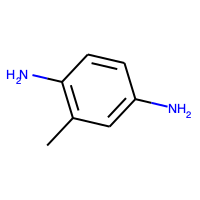
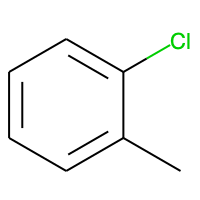
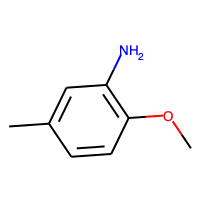
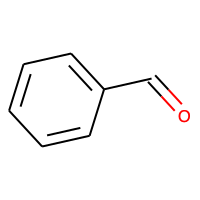
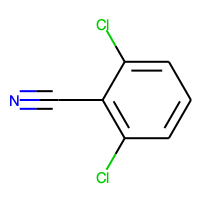
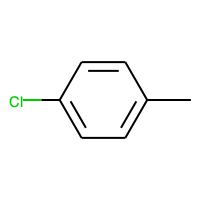
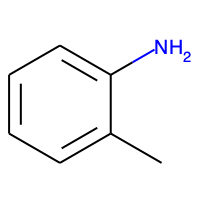
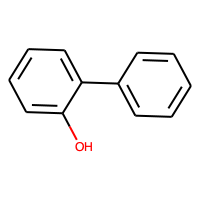
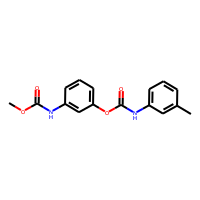
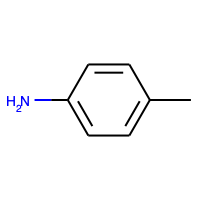
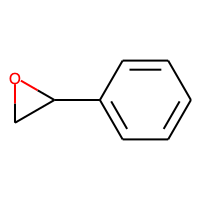
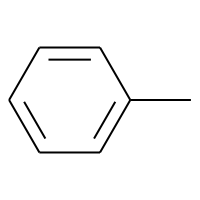
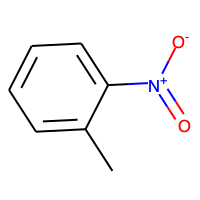

In [129]:
prtr_TCAA_DCAA_list4_target_df

In [116]:
TCAAFP_increase_category2_category3[2]["target"]

intermediate
Oc1cccnc1O              Oc1cccnc1O
[O-]C(=O)CCCC=N    [O-]C(=O)CCCC=N
target                 C1=CC=NC=C1
Name: target, dtype: object

In [20]:
print(len(TCAAFP_increase_category1),
len(TCAAFP_increase_category2),
len(TCAAFP_increase_category3),
len(TCAAFP_increase_category2_category3),
len(DCAAFP_increase_category1),
len(DCAAFP_increase_category2),
len(DCAAFP_increase_category3),
len(DCAAFP_increase_category2_category3),
len(TCAAFP_DCAAFP_increase_category1),
len(TCAAFP_DCAAFP_increase_category2),
len(TCAAFP_DCAAFP_increase_category3),
len(TCAAFP_DCAAFP_increase_category2_category3),
len(TCAAFP_increase_category4),
len(DCAAFP_increase_category4),
len(TCAAFP_DCAAFP_increase_category4))

369 52 106 33 354 0 121 0 369 0 66 0 52 32 18


In [16]:
print(len(TCAAFP_increase_category4),
len(DCAAFP_increase_category4),
len(TCAAFP_DCAAFP_increase_category4))

52 19 13


In [44]:
TCAAFP_DCAAFP_increase_category4[18]

IndexError: list index out of range

In [ ]:
prtr_list2_3_target_smiles_df = []
prtr_list2_3_target_list = []
properties = ['IUPACName', 'MolecularFormula','CanonicalSMILES']
for i in higher_intermediate_list3:
    if i["TCAA"].loc["rate"] >= 10:
        tem_df = pd.DataFrame(pcp.get_properties(properties, i["target"].loc["target"],'smiles'))
        tem_df["rate"] = i["TCAA"].loc["rate"]
        tem_df["max_TCAA"] = i["TCAA"].iloc[0]
        prtr_list2_3_target_list.append(tem_df)
prtr_list2_3_target_df = pd.concat(prtr_list2_3_target_list, axis=0)
prtr_list2_3_target_df
prtr_list2_3_target_df.to_csv("prtr_category2and3.csv",header=True,index=False)
    

In [32]:
result_intermediate_dic["C1=CC(=CC=C1O)O"]
tcaa_list = np.exp(result_intermediate_dic["C1=CC(=CC=C1O)O"]["TCAA"])-1
tcaa_list.index.values
exp_list = [80,320]
height = exp_list
label = ["<1","<24"]
left = [1,2]

<BarContainer object of 2 artists>

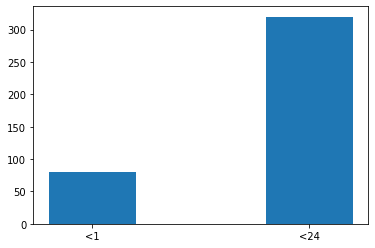

In [31]:
plt.bar(left, height,tick_label = label, width=0.4,zorder=1)

In [116]:
result_intermediate_dic["C1=CC(=CC=C1O)O"]
tcaa_list = np.exp(result_intermediate_dic["C1=CC(=CC=C1O)O"]["TCAA"])-1
tcaa_list.index.values

array(['Oc1ccc(O)c(O)c1', 'Oc1ccc(O)c(O)c1O', 'target',
       '[O-]C(=O)CC(=O)\\C=C/C([O-])=O'], dtype=object)

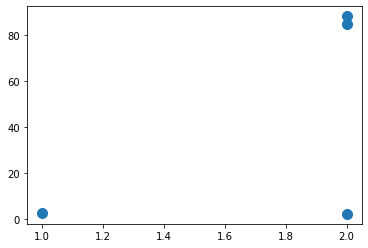

In [134]:
x = []
y = []
b_pos = 1
f_pos = 2
for i in result_intermediate_dic["C1=CC(=CC=C1O)O"].itertuples():
    if i.target == "C1=CC(=CC=C1O)O":
        x.append(b_pos)
    else:
        x.append(f_pos)
    y.append(np.exp(i.TCAA)-1)
plt.scatter(x,y,s = 100,zorder=2)

,TCAA,DCAA,target,ROMol,ATS4Z,ATS4m,ATS1i,ATSC3dv,ATSC5are,AATSC0are,nBondsM,nBondsKD,C2SP2,Xch-7d,SaasC,SsOH,PEOE_VSA1,SMR_VSA7,SlogP_VSA11,EState_VSA7,VSA_EState9,piPC4
intermediate,,,,,,,,,,,,,,,,,,,,,,
Oc1ccc(O)c(O)c1,4.490888,4.214814,Oc1ccc(O)c(O)c1,,315.0,1043.266032,2235.716595,-25.680000,0.755200,0.229600,6,3,6,0.204124,-0.603611,26.039074,15.319582,18.199101,17.248535,0.0,29.000000,3.986667
Oc1ccc(O)c(O)c1O,4.450249,3.479065,Oc1ccc(O)c(O)c1O,,462.0,1564.964886,2421.121652,-7.171875,0.060313,0.264844,6,3,6,0.222222,-2.342037,34.861111,20.426110,12.132734,22.998047,0.0,34.666667,4.141149
target,1.228337,2.236037,C1=CC(=CC=C1O)O,,182.0,551.789034,2050.311538,-31.204082,1.573265,0.181224,6,3,6,0.166667,0.338519,17.291111,10.213055,24.265468,11.499024,0.0,23.333333,3.803881
[O-]C(=O)CC(=O)\C=C/C([O-])=O,1.126041,1.189040,[O-]C(=O)CC(=O)\C=C/C([O-])=O,,490.0,1860.125645,2013.178613,-71.506667,0.629156,0.293156,4,4,3,0.000000,0.000000,0.000000,19.802129,12.152040,0.000000,0.0,45.500000,3.178054

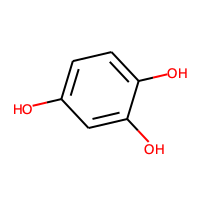
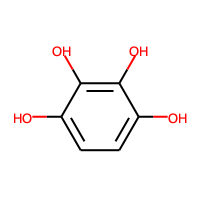
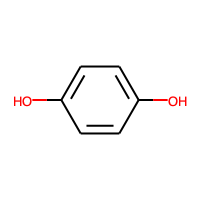
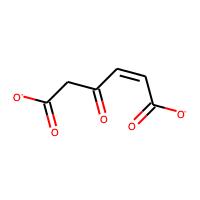

In [75]:
result_intermediate_dic["C1=CC(=CC=C1O)O"]

In [92]:
# Exp_PRTR_df1 = pd.read_excel("/Users/moriirei/Desktop/研究室/modeling of biodegradation/python of model/excel_py/PRTR_CAS.xlsx", header=0)
# Exp_PRTR_df2 = pd.read_excel("/Users/moriirei/Desktop/研究室/modeling of biodegradation/python of model/excel_py/HAA_ugmgC_Table&Figures_STOTEN.xlsx", header=0,sheet_name=1)
# Exp_PRTR_df2 = Exp_PRTR_df2.iloc[:53]
# Exp_PRTR_df1.shape
# Exp_PRTR_df = pd.concat([Exp_PRTR_df1,Exp_PRTR_df2], axis=1)
# Exp_PRTR_df = pd.DataFrame(Exp_PRTR_df[["PRTR number","SMILES","Name","DCAA before","TCAA before","DCAA after","TCAA after"]])
# Exp_PRTR_df.to_csv("excel_py/Exp_PRTR.csv",header=True,index=False)

In [45]:
Exp_PRTR_df = pd.read_excel("/Users/moriirei/Desktop/研究室/modeling of biodegradation/python of model/excel_py/Exp_PRTR.xlsx", header=0)
Exp_PRTR_df

,PRTR number,SMILES,Name,Name.1,DCAA before,TCAA before,DCAA after,TCAA after
0,2,C=CC(=O)N,acrylamide,acrylamide,2.550000,1.266667,0.150730,0.000000
1,4,C=CC(=O)O,acrylic acid,acrylic acid,3.751714,0.389643,191.203988,3.000000
2,5,CN(C)CCOC(=O)C=C,2-(dimethylamino)ethyl acrylate,2-(dimethylamino)ethyl acrylate,0.787667,0.521000,0.624060,1.954887
3,8,COC(=O)C=C,methyl acrylate,methyl acrylate,0.528000,0.072960,6.500000,8.975000
4,14,CC(C)(C#N)O,acetone cyanohidrin,acetone cyanohidrin,1.011000,0.039333,3.449468,2.912234
5,16,CC(C)(C#N)N=NC(C)(C)C#N,"2,2-azobis(isobutyronitrile)","2,2-azobis(isobutyronitrile)",1.701000,0.111667,1.815331,1.198606
6,17,COC1=CC=CC=C1N,2-anisidine,2-anisidine,12.546800,103.260756,10.667797,9.305085
7,18,C1=CC=C(C=C1)N,aniline,aniline,19.485800,49.028401,11.552381,27.384127
8,24,C1=CC(=CC(=C1)O)N,3-aminophenol,3-aminophenol,12.654434,10.703364,10.170671,31.502900
9,69,C1C(O1)COC2=CC=CC=C2,2-(phenoxymethyl)oxirane,2-(phenoxymethyl)oxirane,1.087888,0.752484,3.865942,2.989130


In [143]:
def showGraph(smiles):
    x = []
    y = []
    b_pos = 1
    f_pos = 2
    for i in result_intermediate_dic[smiles].itertuples():
        if i.target == smiles:
            x.append(b_pos)
        else:
            x.append(f_pos)
        y.append(np.exp(i.TCAA)-1)
    plt.scatter(x,y,s = 100,zorder=2)
    tem_df = Exp_PRTR_df[Exp_PRTR_df["SMILES"] == smiles]
    TCAA_before = float(tem_df["TCAA before"])
    TCAA_after = float(tem_df["TCAA after"])
    DCAA_before = float(tem_df["DCAA before"])
    DCAA_after = float(tem_df["DCAA after"])
    exp_tcaa = [TCAA_before,TCAA_after]
    exp_dcaa = [DCAA_before,DCAA_after]
    height = exp_tcaa
    label = ["<1","<24"]
    left = [1,2]
    plt.bar(left, height,tick_label = label, width=0.4,zorder=1)

In [198]:
showGraph(Exp_PRTR_df["SMILES"].iloc[1])

KeyError: 'C=CC(=O)O'

In [106]:
Exp_PRTR_df[Exp_PRTR_df["SMILES"] == "C=CC(=O)N"]

,PRTR number,SMILES,Name,Name.1,DCAA before,TCAA before,DCAA after,TCAA after
0,2,C=CC(=O)N,acrylamide,acrylamide,2.55,1.266667,0.15073,0.0


In [45]:
prtr_8_dic = {}
prtr_8_dic["4-toluidine"] = "CC1=CC=C(C=C1)N"
prtr_8_dic["2-anisidine"] = "COC1=CC=CC=C1N"
prtr_8_dic["3-aminophenol"] = "C1=CC(=CC(=C1)O)N"
prtr_8_dic["benzaldehyde"] = "C1=CC=C(C=C1)C=O"
prtr_8_dic["2-phenylphenol"] = "C1=CC=C(C=C1)C2=CC=CC=C2O"
prtr_8_dic["2-nitrotoluene"] = "CC1=CC=CC=C1[N+](=O)[O-]"
prtr_8_dic["styrene oxide"] = "C1C(O1)C2=CC=CC=C2"
prtr_8_dic["methyl-4-hydroxybenzoate"] = "COC(=O)C1=CC=C(C=C1)O"

In [46]:
def createResult(name):
    tem_df = result_intermediate_dic[prtr_8_dic[name]][["TCAA","DCAA","ROMol"]].transpose()
    tem_df.loc["TCAA"] = [np.exp(i)-1 for i in list(tem_df.loc["TCAA"])]
    tem_df.loc["DCAA"] = [np.exp(i)-1 for i in list(tem_df.loc["DCAA"])]
    return tem_df

intermediate,Cc1ccc(N)c(O)c1O,Cc1ccc(N)cc1O,Cc1ccc(O)c(O)c1,Cc1ccc(N)c(O)c1,Nc1ccc(CO)cc1,target,N
TCAA,170.856,46.5817,46.2169,27.9698,9.54058,1.67726,1.46463
DCAA,10.4243,10.131,7.8348,8.51913,7.53078,2.20248,0.270577
ROMol,,,,,,,

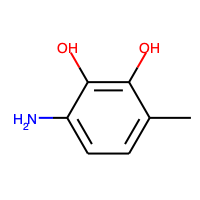
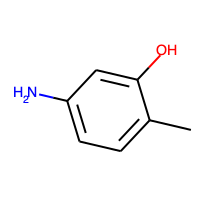
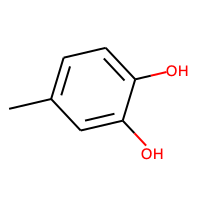
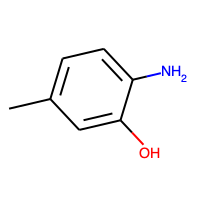
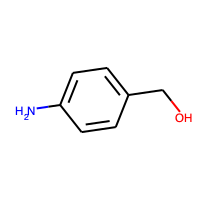
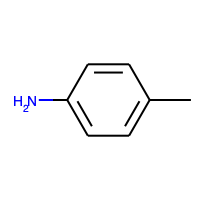
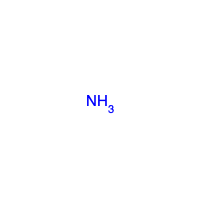

In [47]:
createResult("4-toluidine")

intermediate,COc1cccc(O)c1O,COc1c(N)ccc(O)c1O,COc1ccc(O)c(O)c1N,COc1cc(O)c(O)cc1N,Nc1ccccc1O,target,C=O,N
TCAA,221.899,211.238,142.123,94.1756,21.428,5.83103,1.56057,1.46463
DCAA,8.4162,7.57583,10.1578,11.3816,6.40482,8.19823,0.151357,0.270577
ROMol,,,,,,,,

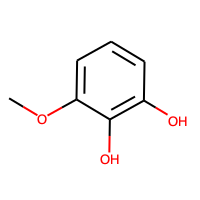
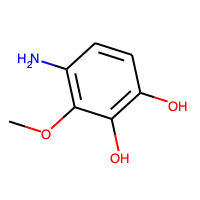
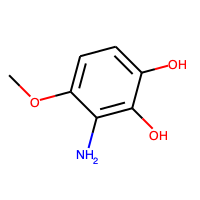
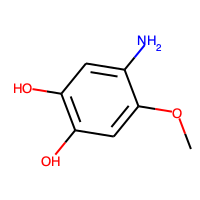
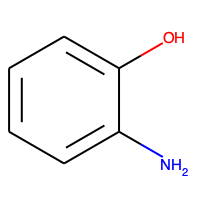
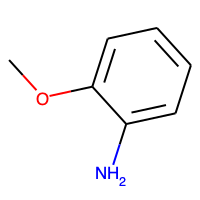
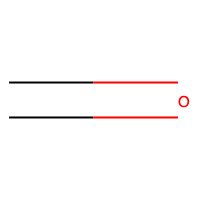
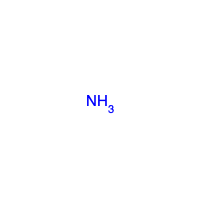

In [48]:
createResult("2-anisidine")

intermediate,Cc1cccc(O)c1O,Cc1cccc(O)c1[N+]([O-])=O,Cc1cc(O)ccc1[N+]([O-])=O,Cc1ccccc1N,Cc1ccccc1NO,target
TCAA,80.0341,28.3364,23.3102,3.86386,1.498,0.429327
DCAA,9.27982,4.3298,9.82386,5.78932,1.48903,1.22885
ROMol,,,,,,

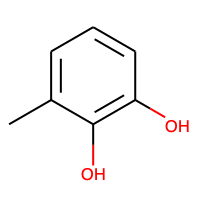
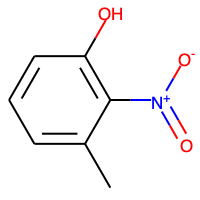
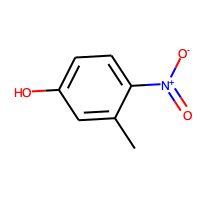
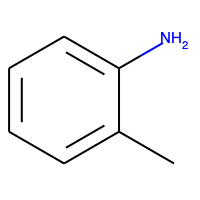
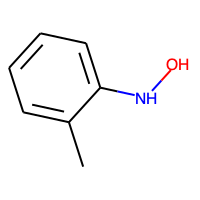
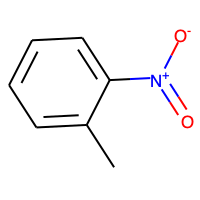

In [49]:
createResult("2-nitrotoluene")

intermediate,Oc1ccccc1C=O,Oc1ccc(C=O)cc1,Oc1cccc(C=O)c1,[O-]C(=O)c1ccccc1,target
TCAA,177.521,154.445,132.367,10.8118,0.937555
DCAA,5.73099,7.22474,6.78973,0.930887,0.867913
ROMol,,,,,

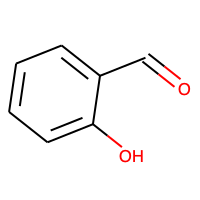
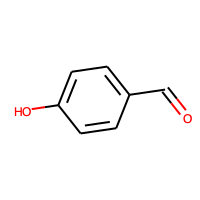
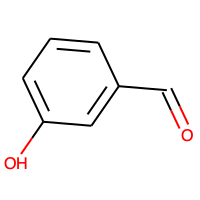
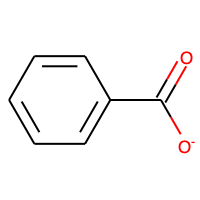
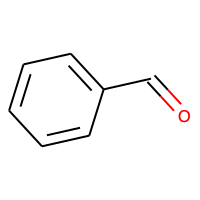

In [50]:
createResult("benzaldehyde")

intermediate,Oc1cccc(C2CO2)c1O,Oc1ccccc1C1CO1,Oc1cccc(c1)C1CO1,Oc1ccc(cc1)C1CO1,OCC(O)c1ccccc1,O=CCc1ccccc1,target
TCAA,218.556,25.1273,22.0107,20.371,5.12722,0.883239,0.784764
DCAA,8.04826,5.09153,5.11032,6.91181,2.404,1.10431,1.03045
ROMol,,,,,,,

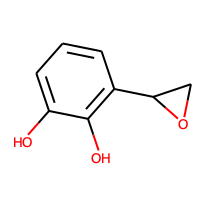
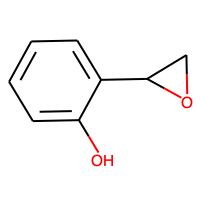
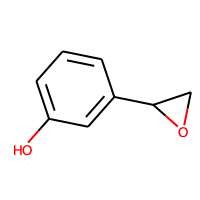
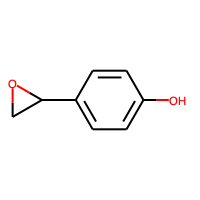
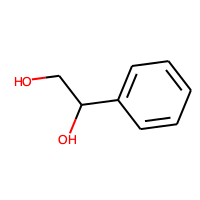
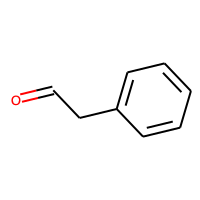
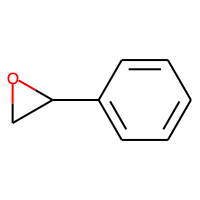

In [51]:
createResult("styrene oxide")

intermediate,Oc1cccc(c1O)-c1ccccc1O,Oc1ccc(cc1)-c1ccccc1O,Oc1ccccc1-c1ccccc1O,Oc1cccc(c1)-c1ccccc1O,Oc1cccc(c1O)-c1ccccc1,target,Oc1ccc(c(O)c1)-c1ccccc1,Oc1cccc(O)c1-c1ccccc1,Oc1ccc(O)c(c1)-c1ccccc1
TCAA,81.0596,34.649,23.1929,8.43186,5.68291,5.60982,4.82572,4.78135,4.05131
DCAA,12.3158,14.1459,10.3608,14.8452,9.90752,5.68169,14.0735,10.0048,15.1893
ROMol,,,,,,,,,

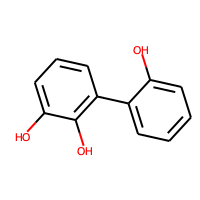
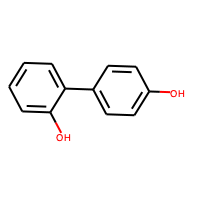
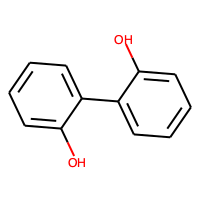
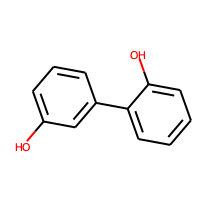
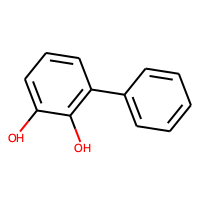
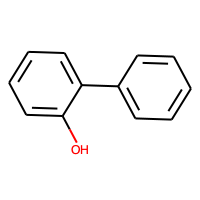
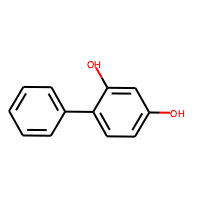
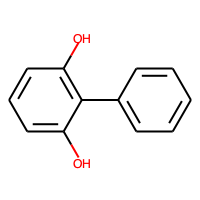
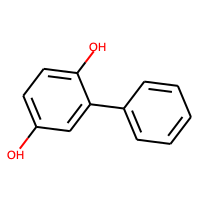

In [52]:
createResult("2-phenylphenol")

intermediate,Nc1cc(O)cc(O)c1O,Nc1cc(O)c(O)c(O)c1,Nc1cccc(O)c1O,Oc1cccc(O)c1O,Nc1ccc(O)c(O)c1,Oc1ccc(O)c(O)c1,Nc1cc(O)ccc1O,Oc1cccc(O)c1,target,N
TCAA,5.20136,5.15092,5.11877,5.0609,4.72157,4.49089,4.31216,3.73382,3.50814,0.902041
DCAA,4.11892,3.99861,3.73222,4.10239,3.89804,4.21481,3.43052,3.19919,3.22091,0.154947
ROMol,,,,,,,,,,

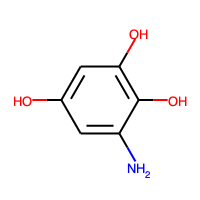
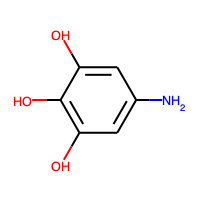
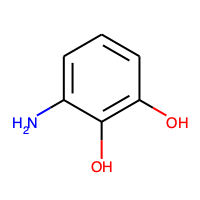
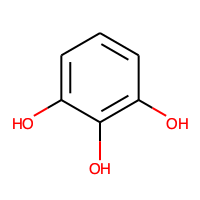
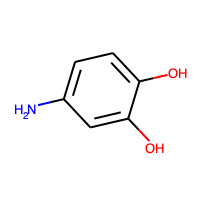
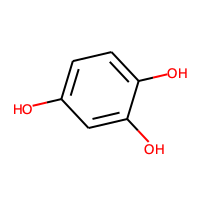
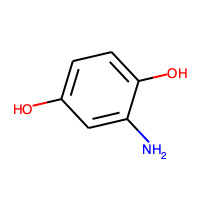
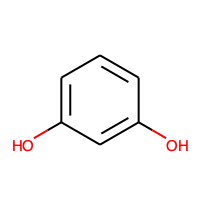
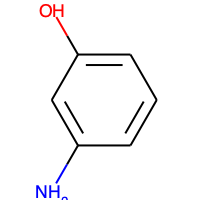
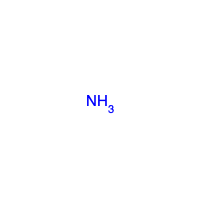

In [68]:
result_intermediate_dic["C1=CC(=CC(=C1)O)N"][["TCAA","DCAA","ROMol"]].transpose()

In [97]:
Exp_PRTR_df

,PRTR number,SMILES,Name,Name.1,DCAA before,TCAA before,DCAA after,TCAA after
0,2,C=CC(=O)N,acrylamide,acrylamide,2.550000,1.266667,0.150730,0.000000
1,4,C=CC(=O)O,acrylic acid,acrylic acid,3.751714,0.389643,191.203988,3.000000
2,5,CN(C)CCOC(=O)C=C,2-(dimethylamino)ethyl acrylate,2-(dimethylamino)ethyl acrylate,0.787667,0.521000,0.624060,1.954887
3,8,COC(=O)C=C,methyl acrylate,methyl acrylate,0.528000,0.072960,6.500000,8.975000
4,14,CC(C)(C#N)O,acetone cyanohidrin,acetone cyanohidrin,1.011000,0.039333,3.449468,2.912234
5,16,CC(C)(C#N)N=NC(C)(C)C#N,"2,2-azobis(isobutyronitrile)","2,2-azobis(isobutyronitrile)",1.701000,0.111667,1.815331,1.198606
6,17,COC1=CC=CC=C1N,2-anisidine,2-anisidine,12.546800,103.260756,10.667797,9.305085
7,18,C1=CC=C(C=C1)N,aniline,aniline,19.485800,49.028401,11.552381,27.384127
8,24,C1=CC(=CC(=C1)O)N,3-aminophenol,3-aminophenol,12.654434,10.703364,10.170671,31.502900
9,69,C1C(O1)COC2=CC=CC=C2,2-(phenoxymethyl)oxirane,2-(phenoxymethyl)oxirane,1.087888,0.752484,3.865942,2.989130


In [19]:
category_df = pd.DataFrame(columns = ["t_1","t_2","t_3","t_4","d_1","d_2","d_3","d_4","td_1","td_2","td_3","td_4","tord_1","tord_2","tord_3","tord_4"])

for target in target_list:
    t_1 = 0
    t_2 = 0
    t_3 = 0
    t_4 = 0
    d_1 = 0
    d_2 = 0
    d_3 = 0
    d_4 = 0
    td_1 = 0
    td_2 = 0
    td_3 = 0
    td_4 = 0
    tord_1 = 0
    tord_2 = 0
    tord_3 = 0
    tord_4 = 0
    tem_df = result_intermediate_dic[target]
    if tem_df["target"].loc[tem_df["TCAA"].idxmax()] != target:
        t_1 = 1
    if tem_df["TCAA"].max()/tem_df["TCAA"].loc["target"] >= 10:
        t_2 = 1
    if tem_df["target"].loc[tem_df["TCAA"].idxmin()] == target:
        t_3 = 1
    if tem_df["TCAA"].loc["target"] < 2 and tem_df["TCAA"].max() > 4:
        t_4 = 1
            
    if tem_df["target"].loc[tem_df["DCAA"].idxmax()] != target:
        d_1 = 1
    if tem_df["DCAA"].max()/tem_df["DCAA"].loc["target"] >= 10:
        d_2 = 1
    if tem_df["target"].loc[tem_df["DCAA"].idxmin()] == target:
        d_3 = 1
    if tem_df["DCAA"].loc["target"] < 2 and tem_df["DCAA"].max() > 4:
        d_4 = 1     
        
    if tem_df["target"].loc[tem_df["DCAA"].idxmax()] != target and tem_df["target"].loc[tem_df["TCAA"].idxmax()] != target:
        td_1 = 1
    if tem_df["DCAA"].max()/tem_df["DCAA"].loc["target"] >= 10 and tem_df["TCAA"].max()/tem_df["TCAA"].loc["target"] >= 10:
        td_2 = 1
    if tem_df["target"].loc[tem_df["DCAA"].idxmin()] == target and tem_df["target"].loc[tem_df["TCAA"].idxmin()] == target:
        td_3 = 1
    if tem_df["DCAA"].loc["target"] < 2 and tem_df["DCAA"].max() > 4 and tem_df["TCAA"].loc["target"] < 2 and tem_df["TCAA"].max() > 4:
        td_4 = 1     
    
    if tem_df["target"].loc[tem_df["DCAA"].idxmax()] != target or tem_df["target"].loc[tem_df["TCAA"].idxmax()] != target:
        tord_1 = 1
    if tem_df["DCAA"].max()/tem_df["DCAA"].loc["target"] >= 10 or tem_df["TCAA"].max()/tem_df["TCAA"].loc["target"] >= 10:
        tord_2 = 1
    if tem_df["target"].loc[tem_df["DCAA"].idxmin()] == target or tem_df["target"].loc[tem_df["TCAA"].idxmin()] == target:
        tord_3 = 1
    if tem_df["DCAA"].loc["target"] < 2 and tem_df["DCAA"].max() > 4 or tem_df["TCAA"].loc["target"] < 2 and tem_df["TCAA"].max() > 4:
        tord_4 = 1   
    category_df.loc[target] = [t_1,t_2,t_3,t_4,d_1,d_2,d_3,d_4,td_1,td_2,td_3,td_4,tord_1,tord_2,tord_3,tord_4]

t_1 = 0
t_2 = 0
t_3 = 0
t_4 = 0
d_1 = 0
d_2 = 0
d_3 = 0
d_4 = 0
td_1 = 0
td_2 = 0
td_3 = 0
td_4 = 0
tord_1 = 0
tord_2 = 0
tord_3 = 0
tord_4 = 0
for i in category_df.itertuples():
    if i.t_1 > 0:
        t_1 = t_1 + 1
    if i.t_2 > 0:
        t_2 = t_2 + 1
    if i.t_3 > 0:
        t_3 = t_3 + 1
    if i.t_4 > 0:
        t_4 = t_4 + 1
    if i.d_1 > 0:
        d_1 = d_1 + 1
    if i.d_2 > 0:
        d_2 = d_2 + 1
    if i.d_3 > 0:
        d_3 = d_3 + 1
    if i.d_4 > 0:
        d_4 = d_4 + 1
    if i.td_1 > 0:
        td_1 = td_1 + 1
    if i.td_2 > 0:
        td_2 = td_2 + 1
    if i.td_3 > 0:
        td_3 = td_3 + 1
    if i.td_4 > 0:
        td_4 = td_4 + 1
    if i.tord_1 > 0:
        tord_1 = tord_1 + 1
    if i.tord_2 > 0:
        tord_2 = tord_2 + 1
    if i.tord_3 > 0:
        tord_3 = tord_3 + 1
    if i.tord_4 > 0:
        tord_4 = tord_4 + 1
print(t_1,t_2,t_3,t_4,d_1,d_2,d_3,d_4,td_1,td_2,td_3,td_4,tord_1,tord_2,tord_3,tord_4)



369 52 106 52 372 7 129 17 338 3 75 10 403 56 160 59


In [20]:
t_2_3 = 0
t_2_4 = 0
t_3_4 = 0
t_2_3_4 = 0
d_2_3 = 0
d_2_4 = 0
d_3_4 = 0
d_2_3_4 = 0
td_2_3 = 0
td_2_4 = 0
td_3_4 = 0
td_2_3_4 = 0
tord_2_3 = 0
tord_2_4 = 0
tord_3_4 = 0
tord_2_3_4 = 0
for i in category_df.itertuples():
    if i.t_2 > 0 and i.t_3 > 0:
        t_2_3 = t_2_3 + 1
    if i.t_2 > 0 and i.t_4 > 0:
        t_2_4 = t_2_4 + 1
    if i.t_3 > 0 and i.t_4 > 0:
        t_3_4 = t_3_4 + 1
    if i.t_2 > 0 and i.t_3 > 0 and i.t_4 > 0:
        t_2_3_4 = t_2_3_4 + 1
    if i.d_2 > 0 and i.d_3 > 0:
        d_2_3 = d_2_3 + 1
    if i.d_2 > 0 and i.d_4 > 0:
        d_2_4 = d_2_4 + 1
    if i.d_3 > 0 and i.d_4 > 0:
        d_3_4 = d_3_4 + 1
    if i.d_2 > 0 and i.d_3 > 0 and i.d_4 > 0:
        d_2_3_4 = d_2_3_4 + 1
    if i.td_2 > 0 and i.td_3 > 0:
        td_2_3 = td_2_3 + 1
    if i.td_2 > 0 and i.td_4 > 0:
        td_2_4 = td_2_4 + 1
    if i.td_3 > 0 and i.td_4 > 0:
        td_3_4 = td_3_4 + 1
    if i.td_2 > 0 and i.td_3 > 0 and i.td_4 > 0:
        td_2_3_4 = td_2_3_4 + 1
    if i.tord_2 > 0 and i.tord_3 > 0:
        tord_2_3 = tord_2_3 + 1
    if i.tord_2 > 0 and i.tord_4 > 0:
        tord_2_4 = tord_2_4 + 1
    if i.tord_3 > 0 and i.tord_4 > 0:
        tord_3_4 = tord_3_4 + 1
    if i.tord_2 > 0 and i.tord_3 > 0 and i.tord_4 > 0:
        tord_2_3_4 = tord_2_3_4 + 1
print("t_2_3: " + str(t_2_3) + ", t_2_4: " + str(t_2_4) + ", t_3_4: " + str(t_3_4) + ", t_2_3_4: " + str(t_2_3_4) + ", d_2_3: " + str(d_2_3) + ", d_2_4: " + str(d_2_4) + ", d_3_4: " + str(d_3_4) + ", d_2_3_4: " + str(d_2_3_4) + ", td_2_3: " + str(td_2_3) + ", td_2_4: " + str(td_2_4) + ", td_3_4: " + str(td_3_4) + ", td_2_3_4: " + str(td_2_3_4) + ", tord_2_3: " + str(tord_2_3) + ", tord_2_4: " + str(tord_2_4) + ", tord_3_4: " + str(tord_3_4) + ", tord_2_3_4: " + str(tord_2_3_4))
                                                                                             
                                                                                             
                                                                                             

t_2_3: 33, t_2_4: 10, t_3_4: 17, t_2_3_4: 5, d_2_3: 6, d_2_4: 0, d_3_4: 6, d_2_3_4: 0, td_2_3: 2, td_2_4: 0, td_3_4: 1, td_2_3_4: 0, tord_2_3: 40, tord_2_4: 10, tord_3_4: 24, tord_2_3_4: 5


In [76]:
result_intermediate_dic["C1=CC(=CC=C1C=O)[N+](=O)[O-]"]

KeyError: 'C1=CC(=CC=C1C=O)[N+](=O)[O-]'

In [50]:
Exp_PRTR_df.iloc[l]

,PRTR number,SMILES,Name,Name.1,DCAA before,TCAA before,DCAA after,TCAA after
2,5,CN(C)CCOC(=O)C=C,2-(dimethylamino)ethyl acrylate,2-(dimethylamino)ethyl acrylate,0.787667,0.521000,0.624060,1.954887
3,8,COC(=O)C=C,methyl acrylate,methyl acrylate,0.528000,0.072960,6.500000,8.975000
4,14,CC(C)(C#N)O,acetone cyanohidrin,acetone cyanohidrin,1.011000,0.039333,3.449468,2.912234
5,16,CC(C)(C#N)N=NC(C)(C)C#N,"2,2-azobis(isobutyronitrile)","2,2-azobis(isobutyronitrile)",1.701000,0.111667,1.815331,1.198606


In [46]:
l = [2,3,4,5]